In [1]:
# Importing the toolbox (takes several seconds)
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import deeplabcut
import math

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
video_dir = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos'
movname = 'NINJAV_S001_S001_T034_008_c'
video='%s.mp4' % movname
# DLCscorer='DeepCut_resnet50_openfieldOct30shuffle1_15001'
DLCscorer = 'DLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_el'

dataname = str(Path(video).stem) + DLCscorer + '.h5'
#loading output of DLC
results_fpath = os.path.join(video_dir, dataname)
df0 = pd.read_hdf(results_fpath)

In [3]:
scorer = df0.columns.get_level_values(0)[0]
scorer

'DLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000'

In [4]:
from deeplabcut.utils import auxiliaryfunctions
from deeplabcut.utils.video_processor import (
    VideoProcessorCV as vp,)  # used to CreateVideo

from matplotlib.collections import LineCollection


In [5]:
def get_segment_indices(bodyparts2connect, all_bpts):
    bpts2connect = []
    for bpt1, bpt2 in bodyparts2connect:
        if bpt1 in all_bpts and bpt2 in all_bpts:
            bpts2connect.extend(
                zip(
                    *(
                        np.flatnonzero(all_bpts == bpt1),
                        np.flatnonzero(all_bpts == bpt2),
                    )
                )
            )
    return bpts2connect

In [6]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

# segs[b1_ix1] - line segment belonging to animal 1
# segs[b1_ix][0] - first point defining line segment^

def get_centroid(segs, animal='band1'):

    b1_ix1 = 0 if animal=='band1' else 1
    b1_ix2 = 2 if animal=='band1' else 3
    vec_ix = 0

    A=segs[b1_ix1][0,:]
    B=segs[b1_ix1][1,:]

    C=segs[b1_ix2][0,:]
    D=segs[b1_ix2][1,:]
    cx, cy = line_intersection((A, B), (C, D))

    return cx, cy

In [594]:
def align_vectors(a, b):
    b = b / np.linalg.norm(b) # normalize a
    a = a / np.linalg.norm(a) # normalize b
    v = np.cross(a, b)
    # s = np.linalg.norm(v)
    c = np.dot(a, b)

    v1, v2, v3 = v
    h = 1 / (1 + c)

    Vmat = np.array([[0, -v3, v2],
                  [v3, 0, -v1],
                  [-v2, v1, 0]])

    R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
    return R

def calculate_2d_rotmat(u, v):
    v1 = u / np.linalg.norm(u)
    #v2 = (0, 1)
    #theta = np.arccos( np.dot(v1, v) )
    #deg = np.rad2deg(theta)
    #print(theta, deg)
    theta = math.atan2(u[1], u[0]) - math.atan2(v[1], v[0])

    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return rot, theta

#def get_transformed_coords(centered_ap)
def get_2d_rotmat(ix, df_ctr, v=(0, 1)):
    x1, y1 = df_ctr['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
    x2, y2 = df_ctr['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]

    #u = (x1-x2), (y1 - y2)
    u = (x2-x1), (y2 - y1)
    # Rotate
    # v = (0, 1)
    R, theta = calculate_2d_rotmat(u, v)
    return R, theta

#def get_transformed_coords(centered_ap)
def get_2d_rotmat_multiindex(ix, df_ctr, animal, scorer=False, v=(0, 1)):
    if scorer:
        x1, y1 = df_ctr[animal]['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
        x2, y2 = df_ctr[animal]['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]
    else:
        x1, y1 = df_ctr[animal]['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
        x2, y2 = df_ctr[animal]['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]

    #u = (x1-x2), (y1 - y2)
    u = (x2-x1), (y2 - y1)
    # Rotate
    # v = (0, 1)
    R, theta = calculate_2d_rotmat(u, v)
    return R, theta

In [8]:
config_path = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/config.yaml'
cfg = auxiliaryfunctions.read_config(config_path)

In [862]:
animal = 'band1'
#df = df0.loc[:, (slice(None), [animal])].copy()
df = df0.copy()
#df = df0.iloc[7000:8000].copy()
bodyparts = df.columns.get_level_values("bodyparts")[::3]
# df = df0.copy() #
# # df = df0.iloc[7000:8000].copy()
# print(bodyparts2connect)
# bodyparts = df.columns.get_level_values("bodyparts")[::3]
# bodyparts
bodyparts

Index(['eyeLeft', 'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1',
       'mantleL2', 'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3', 'eyeLeft',
       'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1', 'mantleL2',
       'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3'],
      dtype='object', name='bodyparts')

In [864]:
# bodyparts2connect = [['mantleA', 'mantleR1'], ['mantleR1', 'mantleR2'],\
#                      ['mantleR2', 'mantleR3'], ['mantleR3', 'mantleP'],\
#                      ['mantleP', 'mantleL3'], ['mantleL3', 'mantleL2'],\
#                      ['mantleL2', 'mantleL1'], ['mantleL1', 'mantleA']]
bodyparts2connect = cfg['skeleton']
n_bodyparts = len(np.unique(bodyparts2connect))
print(n_bodyparts)
all_bpts = df.columns.get_level_values("bodyparts")[::3][0:n_bodyparts]
print(all_bpts)
#all_bpts = df.columns.get_level_values("bodyparts")[::3]
inds = get_segment_indices(bodyparts2connect, all_bpts)
print(inds) # these are used to index into coords

bodyparts = df.columns.get_level_values("bodyparts")[::3]

11
Index(['eyeLeft', 'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1',
       'mantleL2', 'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3'],
      dtype='object', name='bodyparts')
[(2, 0), (2, 1), (0, 1), (2, 3), (3, 4), (3, 5), (5, 6), (6, 7), (7, 4), (4, 10), (10, 9), (9, 8), (8, 3), (6, 9)]


In [865]:
nx = int(np.nanmax(df.xs("x", axis=1, level="coords")))
ny = int(np.nanmax(df.xs("y", axis=1, level="coords")))
dpi=200

# Center

In [866]:
fov_x = int(np.nanmax(df.xs("x", axis=1, level="coords")))
fov_y = int(np.nanmax(df.xs("y", axis=1, level="coords")))
dpi=200
print(fov_x, fov_y)

2064 2007


In [867]:
# calculate center for AP/ML mantle axis
a = df[scorer]['band1']['mantleA'][['x', 'y']].values
p = df[scorer]['band1']['mantleP'][['x', 'y']].values

lt = df[scorer]['band1']['mantleL2'][['x', 'y']].values
rt = df[scorer]['band1']['mantleR2'][['x', 'y']].values

ctrs = np.array([line_intersection( (a_, p_), (lt_, rt_) ) \
                 for a_, p_, lt_, rt_ in zip(a, p, lt, rt)])

In [868]:
animal = 'band1'
animals=['band1', 'band2']

In [869]:
d_=[]
for animal in animals:
    ctr_dict = dict((k, {}) for k in all_bpts)
    for bp in all_bpts:
        xv = df[scorer][animal][bp]['x'] - ctrs[:, 0]
        yv = df[scorer][animal][bp]['y'] - ctrs[:, 1]
        ctr_dict[bp]['x'] = xv
        ctr_dict[bp]['y'] = yv
        ctr_dict[bp]['likelihood'] = df[scorer][animal][bp]['likelihood']
    # turn into dataframe
    reform = {(outerKey, innerKey): values for outerKey, innerDict in ctr_dict.items() \
              for innerKey, values in innerDict.items()}
    tmpdf = pd.DataFrame(reform)
    d_.append(tmpdf)

In [870]:
df_ctr = pd.concat({animals[0]: d_[0], animals[1]: d_[1]},axis=1)
df_ctr.columns = df_rot.columns.rename('individuals', level=0)
df_ctr.columns = df_rot.columns.rename('bodyparts', level=1)
df_ctr.columns = df_rot.columns.rename('coords', level=2)
df_ctr.shape, df.shape

((8991, 66), (8991, 66))

## Rotate

In [871]:
n_frames_ctr = df_ctr.shape[0]
xyp_ctr = df_ctr.values.reshape((n_frames_ctr, -1, 3)) #.shape

In [872]:
target_animal='band1'
v=(0, 1)
df_=[]
#for animal in animals:
d_=[]
for ix in df_ctr.index.tolist():
    R, theta = get_2d_rotmat_multiindex(ix, df_ctr, target_animal, scorer=False, v=(0, 1))
    #R, theta = get_2d_rotmat(ix, df_ctr, v=v)
    coords_ctr = xyp_ctr[ix, :, :] # grab first coords
    subcoords = np.array([coords_ctr[:, 0], coords_ctr[:, 1]]).T
    coords_rot = subcoords.dot(R)
    new_coords = np.array([coords_rot[:, 0], coords_rot[:, 1], coords_ctr[:, 2]]).T

    d1 = dict((k, {'x': x, 'y': y, 'likelihood': L}) \
              for k, (x, y, L) in zip(all_bpts, new_coords[0:n_bodyparts]))
    d2 = dict((k, {'x': x, 'y': y, 'likelihood': L}) \
              for k, (x, y, L) in zip(all_bpts, new_coords[n_bodyparts:]))
    
    reform1 = {(outerKey, innerKey): values for outerKey, innerDict in d1.items() \
              for innerKey, values in innerDict.items()}
    tmpdf1 = pd.DataFrame(reform1, index=[ix])
    reform2 = {(outerKey, innerKey): values for outerKey, innerDict in d2.items() \
              for innerKey, values in innerDict.items()}
    tmpdf2 = pd.DataFrame(reform2, index=[ix])
    
    curr_row_list = [tmpdf1, tmpdf2]
    curr_row = pd.concat({animals[0]: curr_row_list[0], animals[1]: curr_row_list[1]},axis=1)
    d_.append(curr_row)
tmpdf0 = pd.concat(d_, axis=0)
#tmpdf2.columns = tmpdf2.columns.rename(animal, level=0)
df_.append(tmpdf0)

In [873]:
df_rot = tmpdf0.copy() #pd.concat({animals[0]: df_[0], animals[1]: df_[1]},axis=1)
df_rot.columns = df_rot.columns.rename('individuals', level=0)
df_rot.columns = df_rot.columns.rename('bodyparts', level=1)
df_rot.columns = df_rot.columns.rename('coords', level=2)
df_rot.shape, df_ctr.shape

((8991, 66), (8991, 66))

In [874]:
n_frames = df_ctr.shape[0]
xyp = tmpdf0.values.reshape((n_frames, -1, 3))
np.nanmin(xyp), np.nanmax(xyp)
c_test = xyp[ix, :, :]

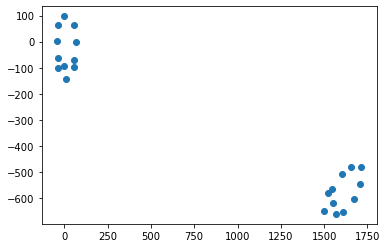

In [875]:
fig, ax  = plt.subplots()
ax.scatter(c_test[:, 0], new_coords[:, 1])

## test 1 frame

In [876]:
%matplotlib inline

In [877]:
xyp = df_rot.values.reshape((n_frames, -1, 3))
np.nanmin(xyp), np.nanmax(xyp)

(-1167.4294569203862, 1733.5698353654664)

In [878]:
currdf = df_rot.copy()

n_frames = currdf.shape[0]
xyp = currdf.values.reshape((n_frames, -1, 3))
print(xyp.shape)
# get coords
coords = xyp[0, :, :2] # grab first coord
coords[xyp[0, :, 2] < pcutoff] = np.nan
segs = coords[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []

nx = int(np.nanmax(currdf.xs("x", axis=1, level="coords")))
ny = int(np.nanmax(currdf.xs("y", axis=1, level="coords")))
dpi=100

(8991, 22, 3)


(-2007.0, 2007.0)

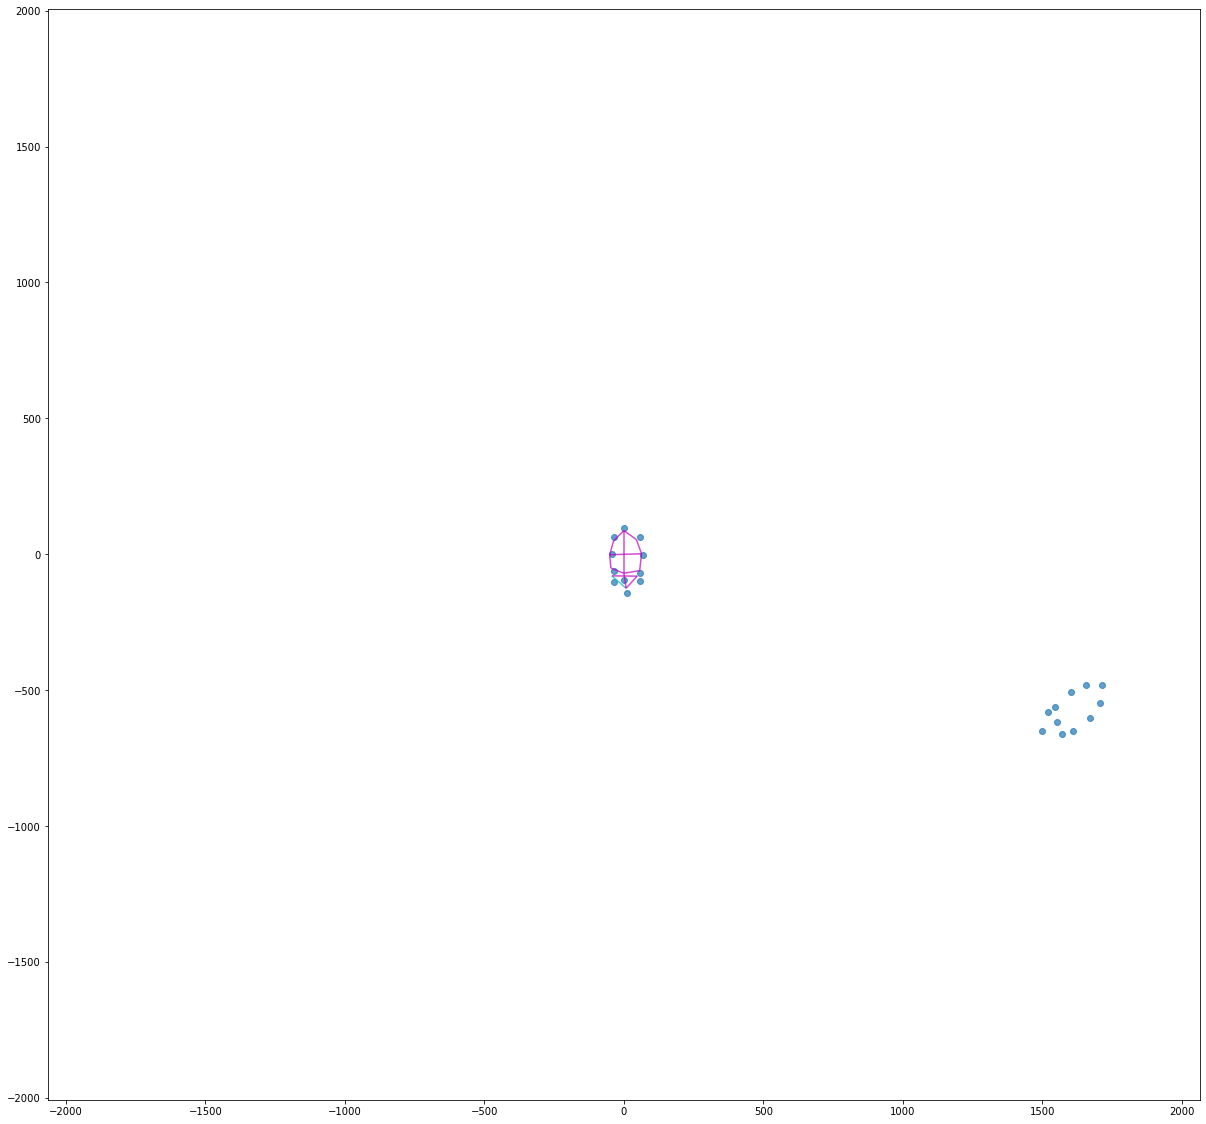

In [879]:
fig = plt.figure(frameon=False, figsize=(fov_x / dpi, fov_y / dpi))
ax = fig.add_subplot(111)
scat = ax.scatter([], [], s=keypoint_size ** 2, alpha=0.7)
scat.set_offsets(coords_rot)

coll = LineCollection(segs[0:1], colors=skeleton_colors[0], alpha=0.7)
col2 = LineCollection(segs[1:], colors=skeleton_colors[1], alpha=0.7)

ax.add_collection(coll)
ax.add_collection(col2)

ax.set_xlim(-fov_x, fov_x)
ax.set_ylim(-fov_y, fov_y)

# ax.plot(segs[1:][0,:][0, 0], segs[1:][0,:][0, 1], 'r*')

# Make movie

In [880]:
from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter
from tqdm import trange

def get_segment_indices(bodyparts2connect, all_bpts):
    bpts2connect = []
    for bpt1, bpt2 in bodyparts2connect:
        if bpt1 in all_bpts and bpt2 in all_bpts:
            bpts2connect.extend(
                zip(
                    *(
                        np.flatnonzero(all_bpts == bpt1),
                        np.flatnonzero(all_bpts == bpt2),
                    )
                )
            )
    return bpts2connect

def create_video_with_keypoints_only(
    df,
    output_name,
    ind_links=None,
    pcutoff=0.6,
    dotsize=8,
    alpha=0.7,
    background_color="k",
    skeleton_color=["navy"],
    color_by="bodypart",
    colormap="viridis",
    fps=25,
    dpi=200,
    codec="h264",
    ylim=(None, None),
    xlim=(None, None),
    figsize=None
):
    bodyparts = df.columns.get_level_values("bodyparts")[::3]
    bodypart_names = bodyparts.unique()
    n_bodyparts = len(bodypart_names)
    nx = int(np.nanmax(df.xs("x", axis=1, level="coords")))
    ny = int(np.nanmax(df.xs("y", axis=1, level="coords")))
    if ylim[0] is None:
        ymin, ymax = (0, ny)
    else:
        ymin, ymax = ylim
    if xlim[0] is None:
        xmin, xmax = (0, nx)
    else:
        xmin, xmax = xlim
        
    n_frames = df.shape[0]
    xyp = df.values.reshape((n_frames, -1, 3))

    if color_by == "bodypart":
        map_ = bodyparts.map(dict(zip(bodypart_names, range(n_bodyparts))))
        cmap = plt.get_cmap(colormap, n_bodyparts)
    elif color_by == "individual":
        try:
            individuals = df.columns.get_level_values("individuals")[::3]
            individual_names = individuals.unique().to_list()
            n_individuals = len(individual_names)
            map_ = individuals.map(dict(zip(individual_names, range(n_individuals))))
            cmap = plt.get_cmap(colormap, n_individuals)
        except KeyError as e:
            raise Exception(
                "Coloring by individuals is only valid for multi-animal data"
            ) from e
    else:
        raise ValueError(f"Invalid color_by={color_by}")

    if figsize is None:
        figsize = (nx / dpi, ny / dpi)
    prev_backend = plt.get_backend()
    plt.switch_backend("agg")
    fig = plt.figure(frameon=False, figsize=figsize)
    ax = fig.add_subplot(111)
    scat = ax.scatter([], [], s=dotsize ** 2, alpha=alpha)
    coords = xyp[0, :, :2]
    coords[xyp[0, :, 2] < pcutoff] = np.nan
    scat.set_offsets(coords)
    colors = cmap(map_)
    scat.set_color(colors)
    segs = coords[tuple(zip(*tuple(ind_links))), :].swapaxes(0, 1) if ind_links else []
    coll = LineCollection(segs, colors=skeleton_color, alpha=alpha)
    ax.add_collection(coll)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    ax.add_patch(
        plt.Rectangle(
            (0, 0), 1, 1, facecolor=background_color, transform=ax.transAxes, zorder=-1
        )
    )
    ax.invert_yaxis()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    writer = FFMpegWriter(fps=fps, codec=codec)
    with writer.saving(fig, output_name, dpi=dpi):
        writer.grab_frame()
        for index, _ in enumerate(trange(n_frames - 1), start=1):
            coords = xyp[index, :, :2]
            coords[xyp[index, :, 2] < pcutoff] = np.nan
            scat.set_offsets(coords)
            if ind_links:
                segs = coords[tuple(zip(*tuple(ind_links))), :].swapaxes(0, 1)
            coll.set_segments(segs)
            writer.grab_frame()
    plt.close(fig)
    plt.switch_backend(prev_backend)


In [1119]:
start=5000
stop=8000 #total_nframes

In [1120]:

skeleton_colors = ['c', 'm']
color_by = "individual"
outputframerate = 30*4
df = df0.copy()
keypoint_cmap = 'cool' #cfg["colormpa"]
keypoint_size = 6 #cfg["dotsize"]

pcutoff = cfg["pcutoff"]

In [1121]:
meta_fpath = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_cDLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_meta.pickle'
video_fpath  = results_fpath.replace('%s_el.h5' % scorer, '.mp4')
print(video_fpath)

/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_c.mp4


In [1122]:
transform = 'rotated'
plotdf = df_rot.copy() #iloc[7000:8000].copy() #df0.iloc[7000:8000].copy()
figsize = (fov_x/2 / dpi, fov_y/2 / dpi)

if transform=='centered':
    xlim=(-nx, nx)
    ylim=(-ny, ny)
elif transform=='rotated':
#     xlim=(-fov_x/2, fov_x),
#     ylim=(-fov_y/2, fov_y)
    xlim=(-1000, 1000)
    ylim=(-1000, 1000)
else:
    xlim=(0, nx)
    ylim=(0, ny)

In [1123]:
# start=6500
# stop=7600 #total_nframes
# start=0
# stop=total_nframes #total_nframes

start=5000
stop=8000 #total_nframes
videooutname = os.path.join(video_dir, 'test-rot_%i-%i.mp4' % (start, stop))

plotdf = df_rot.iloc[start:stop].copy() #df0.iloc[7000:8000].copy()
print(bodyparts2connect)
bodyparts = plotdf.columns.get_level_values("bodyparts")[::3]

nx = int(np.nanmax(plotdf.xs("x", axis=1, level="coords")))
ny = int(np.nanmax(plotdf.xs("y", axis=1, level="coords")))

mask = plotdf.columns.get_level_values("bodyparts").isin(bodyparts)
plotdf.loc[:, ~mask] = np.nan
inds = None
print(videooutname)
if bodyparts2connect:
    all_bpts = plotdf.columns.get_level_values("bodyparts")[::3]
    inds = get_segment_indices(bodyparts2connect, all_bpts)
clip = vp(fname=video_fpath, fps=outputframerate)
create_video_with_keypoints_only(
    plotdf,
    videooutname,
    inds,
    cfg["pcutoff"],
    keypoint_size,
    cfg["alphavalue"],
    skeleton_color=skeleton_colors,
    color_by=color_by,
    colormap=keypoint_cmap,
    fps=clip.fps(),
    xlim=xlim,
    ylim=ylim,
    figsize=(figsize)
)
clip.close()

[['armbase', 'eyeLeft'], ['armbase', 'eyeRight'], ['eyeLeft', 'eyeRight'], ['armbase', 'mantleA'], ['mantleA', 'mantleP'], ['mantleA', 'mantleL1'], ['mantleL1', 'mantleL2'], ['mantleL2', 'mantleL3'], ['mantleL3', 'mantleP'], ['mantleP', 'mantleR3'], ['mantleR3', 'mantleR2'], ['mantleR2', 'mantleR1'], ['mantleR1', 'mantleA'], ['mantleL2', 'mantleR2']]
/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/test-rot_5000-8000.mp4


100%|██████████████████████████████████████| 2999/2999 [01:03<00:00, 47.29it/s]


In [1124]:
videooutname

'/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/test-rot_5000-8000.mp4'

In [888]:
inds_ap = get_segment_indices([['mantleA', 'mantleP']], all_bpts)
inds_ap

[(3, 4), (14, 15)]

In [898]:
all_coords = xyp[:, :, :2]
all_coords[xyp[:, :, 2] < pcutoff] = np.nan

In [913]:
all_coords.shape

(8991, 22, 2)

In [914]:
start=7000
stop=8000
incr = 10

all_coords[start:stop, n_bodyparts:, 0]

array([[  16.97348771,           nan,   71.2858982 , ...,           nan,
        -131.04192995, -193.84558776],
       [   8.4067912 ,           nan,           nan, ...,  -58.71924816,
        -138.68453978, -202.70982816],
       [   7.04839804,           nan,   65.09727089, ...,  -64.70714877,
        -139.9298529 , -204.63151803],
       ...,
       [ 457.83105541,  407.79105122,  380.30282524, ...,  436.31600187,
         482.82587761,  536.90223687],
       [ 458.20859827,  406.32010756,  383.52234946, ...,  436.32448516,
         488.74343605,  534.67846783],
       [ 453.14707972,  402.08976426,  370.27126258, ...,  433.07310835,
         481.83619095,  533.70606992]])

In [924]:
bodyparts

Index(['eyeLeft', 'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1',
       'mantleL2', 'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3', 'eyeLeft',
       'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1', 'mantleL2',
       'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3'],
      dtype='object', name='bodyparts')

In [1023]:
total_nframes = all_coords.shape[0]


In [928]:
ix1, ix2 = np.where(bodyparts=='mantleA')[0]

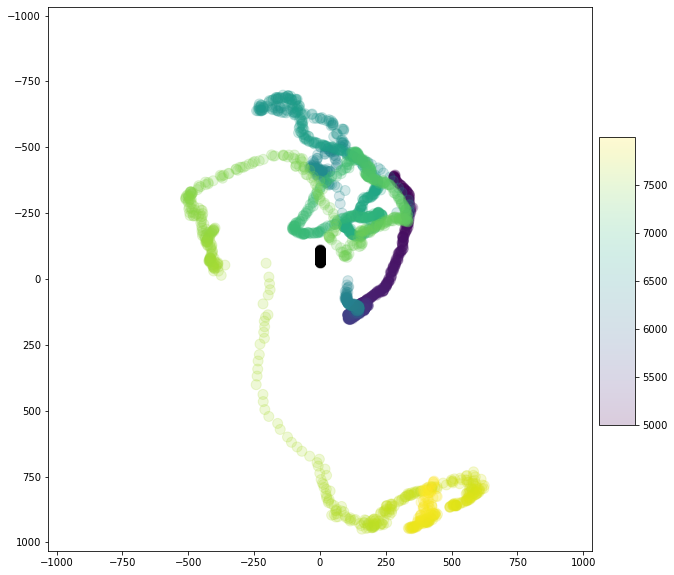

In [1239]:
# start=6500
# stop=7600 #total_nframes
start=5000
stop=8000 #total_nframes

t_cmap = 'viridis'
target_color='k'
n_frames = np.arange(start, stop)

# incr = 10
figsize=(10,10)
if figsize is None:
    figsize = (nx / dpi, ny / dpi)
prev_backend = plt.get_backend()
plt.switch_backend("agg")
fig = plt.figure(frameon=False, figsize=figsize)
ax = fig.add_subplot(111)

scat = ax.scatter(all_coords[start:stop, ix1, 0], \
                  all_coords[start:stop, ix1, 1], alpha=0.2, c=target_color,
                 s=100)
im = ax.scatter(all_coords[start:stop, ix2, 0], \
                  all_coords[start:stop, ix2, 1], alpha=0.2, c=n_frames, cmap=t_cmap,
                s=100)

cax = fig.add_axes([0.9, 0.3, 0.05, 0.4])
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_aspect('equal')

ax.set_xlim(-fov_x/2, fov_x/2)
ax.set_ylim(-fov_x/2, fov_x/2)
ax.invert_yaxis()


In [1240]:
import scipy
import copy

def get_max(image,sigma,alpha=20,size=10):
    i_out = []
    j_out = []
    image_temp = copy.deepcopy(image)
    while True:
        k = np.argmax(image_temp)
        j,i = np.unravel_index(k, image_temp.shape)
        if(image_temp[j,i] >= alpha*sigma):
            i_out.append(i)
            j_out.append(j)
            x = np.arange(i-size, i+size)
            y = np.arange(j-size, j+size)
            xv,yv = np.meshgrid(x,y)
            image_temp[yv.clip(0,image_temp.shape[0]-1),
                                   xv.clip(0,image_temp.shape[1]-1) ] = 0
            #print xv
        else:
            break
    return i_out,j_out

In [1241]:
start, stop

(5000, 8000)

In [1242]:
minv = np.nanmin(all_coords[start:stop, ix2, 0])
maxv = np.nanmax(all_coords[start:stop, ix2, 0])
(minv, maxv)
minv = -650
incr = 10
maxv = 650+incr

In [1243]:
src_dir, _ = os.path.split(video_fpath)
print(src_dir)

/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos


In [1261]:
start, stop
indices = np.arange(start, stop+incr, incr)

In [1262]:
heatmap[heatmap!=0].min()

1.0

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_82485/1701416263.py:20: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed = scipy.ndimage.filters.gaussian_filter(heatmap, sigma, mode='constant')


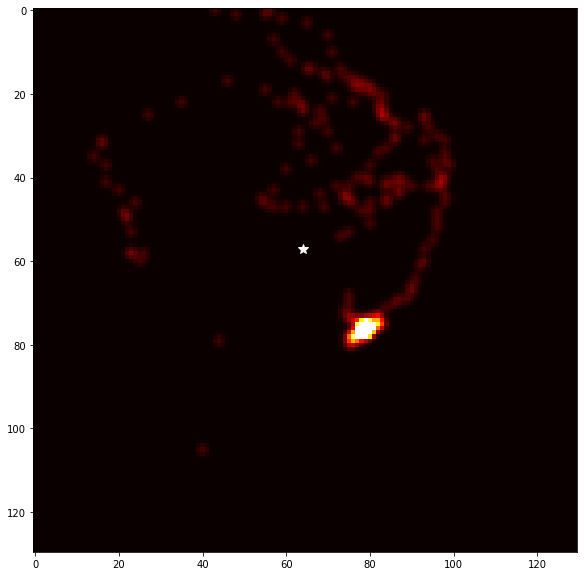

In [1269]:
x=all_coords[indices, ix2, 0]
y=all_coords[indices, ix2, 1]
fig, ax = plt.subplots(figsize=(10,10))

#plt.hist2d(x,y, bins=[np.arange(minv,maxv,incr),np.arange(minv,maxv,incr)])

heatmap, _, _ = np.histogram2d(y[~np.isnan(y)], x[~np.isnan(x)], \
                               bins=np.arange(minv,maxv,incr)) #,np.arange(minv,maxv,incr)])
# heatmap, _, _ = np.histogram2d(x[~np.isnan(x)], y[~np.isnan(y)], \
#                                bins=[np.arange(minv,maxv,incr),np.arange(minv,maxv,incr)])

targ_x = all_coords[indices, ix1, 0]
targ_y = all_coords[indices, ix1, 1]
targ_heatmap, _, _ = np.histogram2d(targ_y[~np.isnan(targ_y)], targ_x[~np.isnan(targ_x)], \
                               bins=np.arange(minv,maxv,incr)) #np.arange(minv,maxv,incr)])
# Apply gaussian filter
sigma_y=1
sigma_x=1
sigma = [sigma_y, sigma_x]
smoothed = scipy.ndimage.filters.gaussian_filter(heatmap, sigma, mode='constant')
#targ_smoothed = scipy.ndimage.filters.gaussian_filter(targ_heatmap, sigma, mode='constant')
ax.imshow(smoothed, cmap='hot', origin='lower', vmin=0, vmax=2) #, cmap='hot')

#getting the peaks
i,j = np.unravel_index(targ_smoothed.argmax(), targ_smoothed.shape)
#ax.imshow(targ_heatmap, cmap='hot', origin='lower')
ax.plot(j, i, 'w*', markersize=10)

ax.invert_yaxis()

#ax.scatter(all_coords[start:stop, ix1, 0], all_coords[start:stop, ix1, 1])
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

fig_path = os.path.join(src_dir, 'heatmap_%i-%i.png' % (start, stop))
plt.savefig(fig_path)

In [1195]:
bins=np.arange(minv,maxv,incr)
bins.min(), bins.max()

(-650, 650)

In [1152]:
min(bins)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1085]:
i,j = np.unravel_index(targ_smoothed.argmax(), targ_smoothed.shape)

print(i, j, targ_smoothed[i, j])

43 50 336.03063609448566


In [1004]:
targ_smoothed.shape

(113, 113)

(array([[ 0., 22., 37., 43., 21.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  8.,  0.,  7., 25.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  0.,  0.,  0.,  0.,  3.,  4.,  3.,  3.,  0.],
        [ 8.,  0.,  0.,  0.,  1.,  4.,  2.,  0.,  0.,  0.,  4.],
        [16., 11., 24., 43.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 3., 19.,  9., 15.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [74., 27.,  0., 29.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 5., 39., 17., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  3., 53.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([-509.39751693, -409.39751693, -309.39751693, -209.39751693,
        -109.39751693,   -9.39751693,   90.60248307,  190.60248307,
         290.60248307,  390.60248307,  490.60248307,  590.60248307]),
 array([-509.39751693, -409.39751693, -309.39751693, -209.39751693,
        -

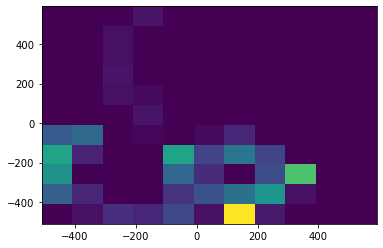

In [965]:
plt.hist2d(x,y, bins=[np.arange(minv,maxv,incr),np.arange(minv,maxv,incr)])


In [919]:
bodyparts

Index(['eyeLeft', 'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1',
       'mantleL2', 'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3', 'eyeLeft',
       'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1', 'mantleL2',
       'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3'],
      dtype='object', name='bodyparts')

In [834]:
plotdf = df_rot.iloc[7000:8000].copy() #df0.iloc[7000:8000].copy()


In [835]:
colormap='cool'

In [836]:
bodyparts = plotdf.columns.get_level_values("bodyparts")[::3]
bodypart_names = bodyparts.unique()
n_bodyparts = len(bodypart_names)
nx = int(np.nanmax(plotdf.xs("x", axis=1, level="coords")))
ny = int(np.nanmax(plotdf.xs("y", axis=1, level="coords")))

n_frames = plotdf.shape[0]
xyp = plotdf.values.reshape((n_frames, -1, 3))

try:
    individuals = plotdf.columns.get_level_values("individuals")[::3]
    individual_names = individuals.unique().to_list()
    n_individuals = len(individual_names)
    map_ = individuals.map(dict(zip(individual_names, range(n_individuals))))
    cmap = plt.get_cmap(colormap, n_individuals)
except KeyError as e:
    raise Exception(
        "Coloring by individuals is only valid for multi-animal data"
    ) from e


In [837]:
dotsize=6
alpha=0.7
skeleton_color=['c', 'm']
background_color='k'

In [838]:
np.nanmin(xyp),  np.nanmax(xyp)

(-649.6204422818475, 1001.3772504908356)

In [842]:
ix = 500

In [712]:
%matplotlib notebook

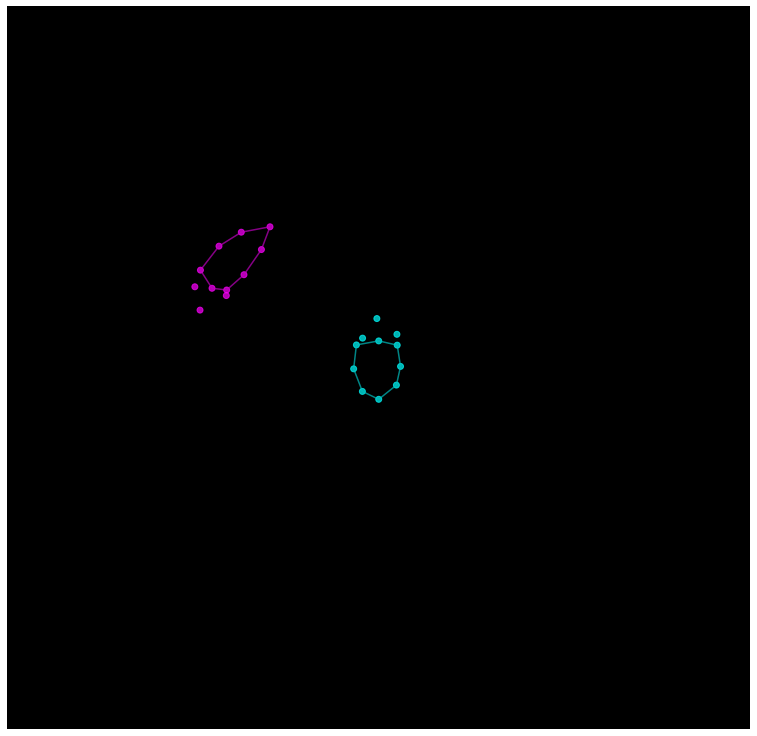

In [846]:
ix=500
prev_backend = plt.get_backend()
#plt.switch_backend("agg")
fig = plt.figure(frameon=False, figsize=(fov_x/2 / dpi, fov_y/2 / dpi))
ax = fig.add_subplot(111)
scat = ax.scatter([], [], s=dotsize ** 2, alpha=alpha)
coords = xyp[ix, :, :2]
coords[xyp[ix, :, 2] < pcutoff] = np.nan
scat.set_offsets(coords)
colors = cmap(map_)
scat.set_color(colors)
segs = coords[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
coll = LineCollection(segs, colors=skeleton_color, alpha=alpha)
ax.add_collection(coll)
# ax.set_xlim(-fov_x/2, fov_x)
# ax.set_ylim(-fov_y/2, fov_y)
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.axis("off")
ax.add_patch(
    plt.Rectangle(
        (0, 0), 1, 1, facecolor=background_color, transform=ax.transAxes, zorder=-1
    )
)
ax.invert_yaxis()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [ ]:
coords

<IPython.core.display.Javascript object>


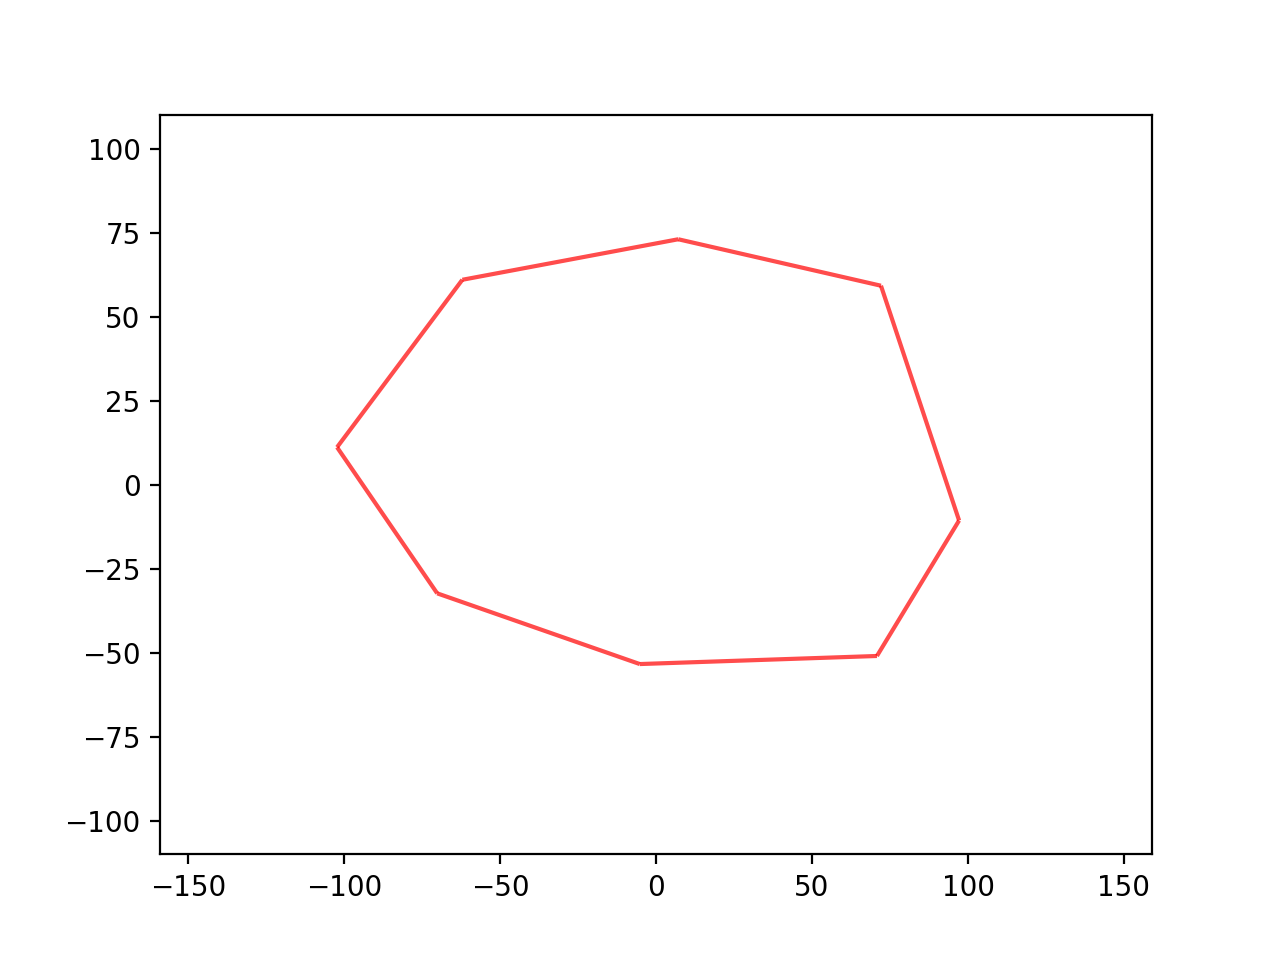

(-110.0, 110.0)

In [278]:
fig, ax  = plt.subplots()
segs = coords[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
coll = LineCollection(segs, colors='r', alpha=alpha)
ax.add_collection(coll)
ax.set_xlim(-nx, nx)
ax.set_ylim(-ny, ny)

In [275]:
-ny

-110

In [99]:
%matplotlib notebook

<IPython.core.display.Javascript object>


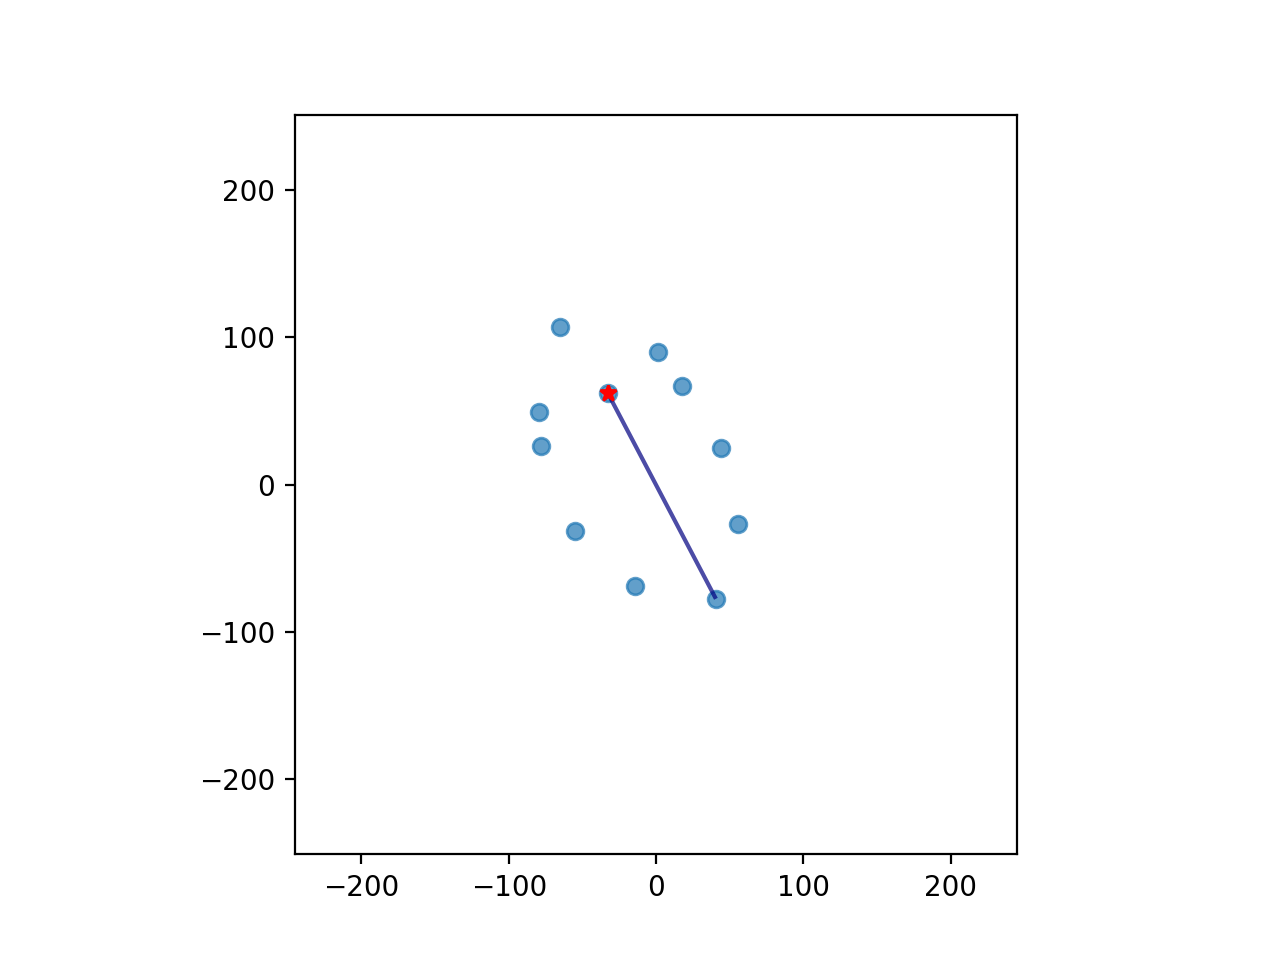

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111)
scat = ax.scatter([], [], s=keypoint_size ** 2, alpha=0.7)
coll = LineCollection( line_coord, colors=t_cmap, alpha=0.7)
scat.set_offsets(coords_ctr) #[0:11])
ax.set_xlim(-nx/8, nx/8)
ax.set_ylim(-ny/8, ny/8)
ax.add_collection(coll)
ax.set_aspect('equal')
ax.plot(ap_coord[0], ap_coord[1], 'r*')

<IPython.core.display.Javascript object>


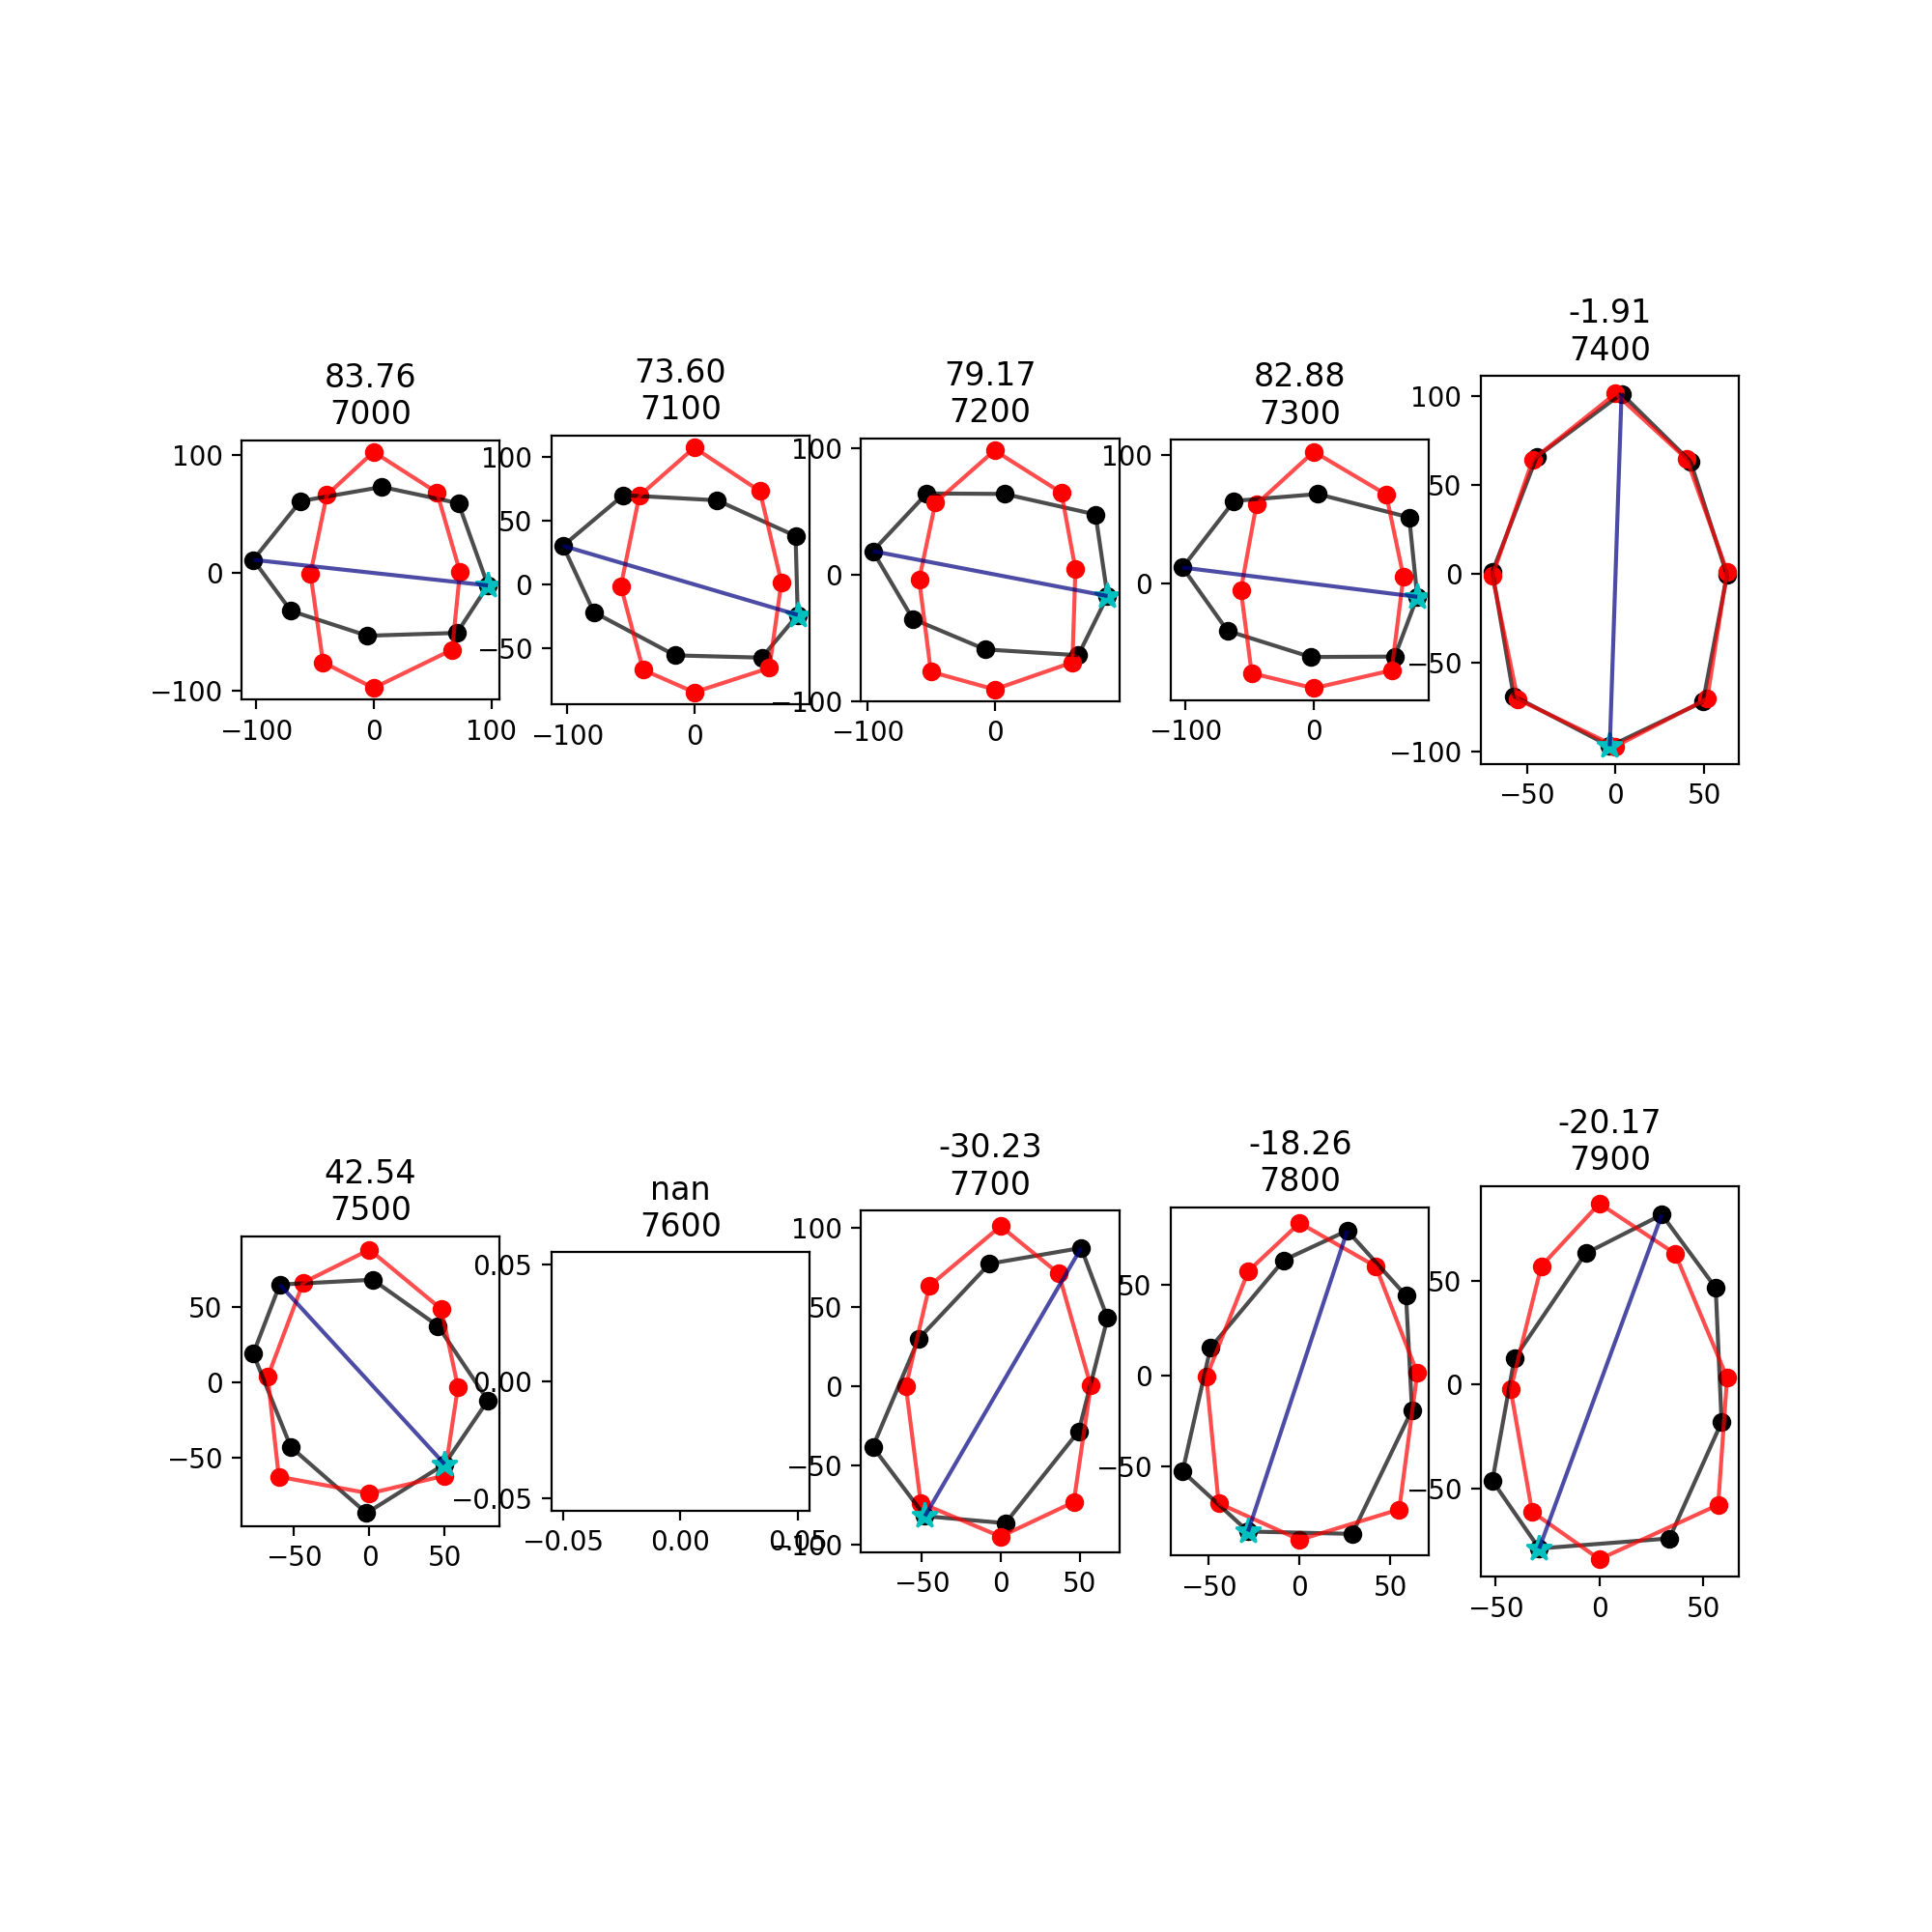

In [128]:
# ---
#fig, ax  = plt.subplots(figsize=(5,5))
start_ix = 7000
stop_ix = 8000
incr = 100
n_subplots = len(np.arange(start_ix, stop_ix, incr))

fig, axes = plt.subplots(2, int(np.floor(n_subplots/2)), figsize=(2*n_subplots/2, 2*n_subplots/2))

for i, ix in enumerate(np.arange(start_ix, stop_ix, incr)):
    ax = axes.flat[i]
    # get rot
    R, theta = get_2d_rotmat(ix, df_ctr, v=v)
    coords_ctr = xyp_ctr[ix, :, :] # grab first coords
    coords_rot = coords_ctr.dot(R)
    # get line
    line_coord = centered_ap[ix]
    line_coord = np.expand_dims(line_coord, 0)
    ap_coord = [centered_ap[ix][0][0], centered_ap[ix][0][1]]

    # not rotated
    ax.scatter(coords_ctr[np.unique(inds), 0], coords_ctr[np.unique(inds), 1], c='k')
    segs = coords_ctr[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) #if inds else []
    coll = LineCollection(segs, colors='k', alpha=0.7)
    ax.add_collection(coll)
    # Rotate
    ax.scatter(coords_rot[np.unique(inds), 0], coords_rot[np.unique(inds), 1], c='r')
    segs_rot = coords_rot[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) #if inds else []
    col2 = LineCollection(segs_rot, colors='r', alpha=0.7)
    ax.add_collection(col2)

    ax.plot(ap_coord[0], ap_coord[1], 'c*', markersize=10)
    col0 = LineCollection( line_coord, colors=t_cmap, alpha=0.7)
    ax.add_collection(col0)
    
    ax.set_aspect('equal')
    
    ax.set_title('%.2f\n%i' % (np.rad2deg(theta), ix), fontsize=12)
    
# plt.subplots_adjust(hspace=0.1)

In [360]:
R

array([[-0.88521254,  0.4651868 ],
       [-0.4651868 , -0.88521254]])

<IPython.core.display.Javascript object>


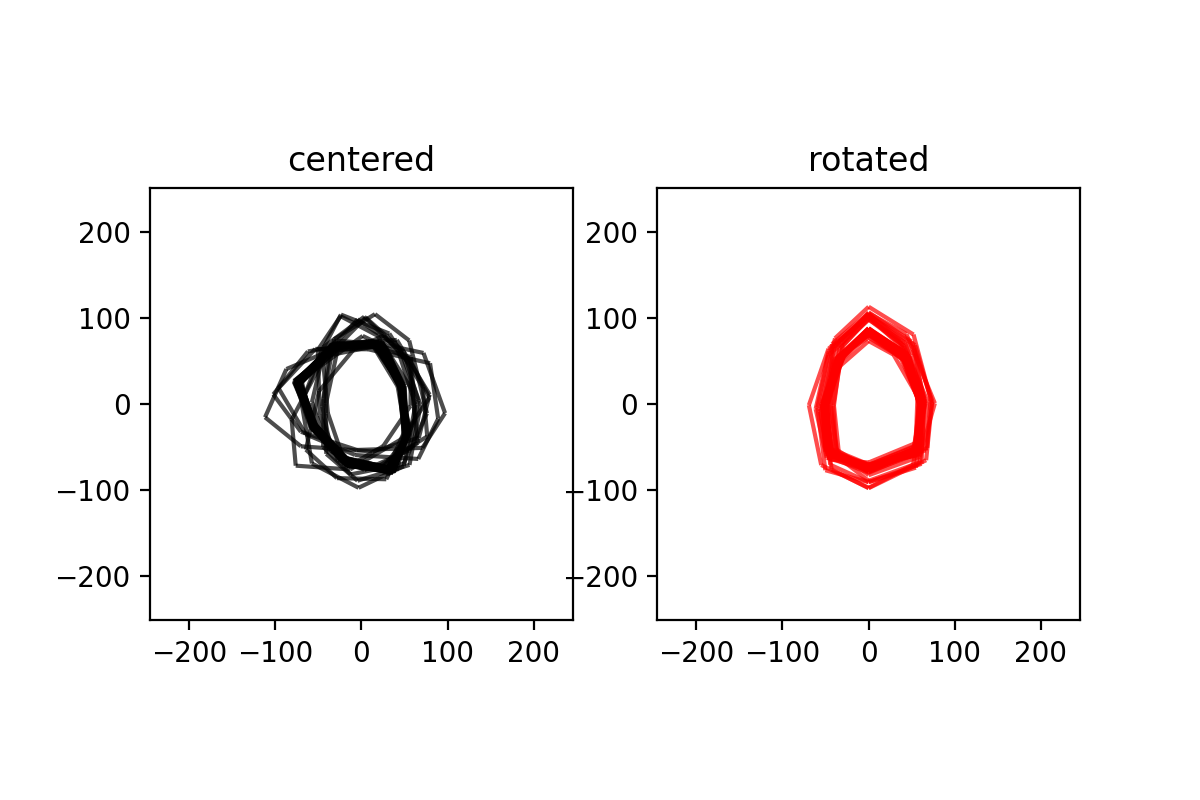

In [129]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(6,4))
ax1.set_title('centered')
ax2.set_title('rotated')
for ix in np.arange(0, 9000, 200):
    R, theta = get_2d_rotmat(ix, df_ctr, v=v)
    coords_ctr = xyp_ctr[ix, :, :] # grab first coords
    coords_rot = coords_ctr.dot(R)

    # not rotated
    #ax1.scatter(coords_ctr[np.unique(inds), 0], coords_ctr[np.unique(inds), 1], c='k')
    segs = coords_ctr[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
    coll = LineCollection(segs, colors='k', alpha=0.7)
    ax1.add_collection(coll)
    # Rotate
    #ax2.scatter(coords_rot[np.unique(inds), 0], coords_rot[np.unique(inds), 1], c='r')
    segs = coords_rot[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
    col2 = LineCollection(segs, colors='r', alpha=0.7)
    ax2.add_collection(col2)

for ax in fig.axes:
    ax.set_aspect('equal')
    ax.set_xlim(-nx/8, nx/8)
    ax.set_ylim(-ny/8, ny/8)

# Apply to image

In [130]:
from PIL import Image, ImageDraw

In [131]:
# !pip install pickle5

In [132]:
# !pip install pickle5
import pickle5 as pkl

In [325]:
meta_fpath = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_cDLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_meta.pickle'
video_fpath  = results_fpath.replace('%s_el.h5' % scorer, '.mp4')
print(video_fpath)

/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_c.mp4


In [326]:
displaycropped=True
with open(meta_fpath, 'rb') as f:
    metadata = pkl.load(f)
# metadata = auxiliaryfunctions.load_video_metadata(
#     video_dir, vname, scorer)
cropping = metadata["data"]["cropping"]
cropping
[x1, x2, y1, y2] = metadata["data"]["cropping_parameters"]
print(x1, x2, y1, y2)
if displaycropped:
    ny, nx= y2-y1,x2-x1
else:
    ny, nx= clip.height(), clip.width()

927 3178 3 2153


In [327]:
print(video_fpath)
clip = vp(fname=video_fpath, fps=30)

/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_c.mp4


In [328]:
im = clip.load_frame()
#im = im[y1:y2, x1:x2]

In [329]:
# plt.figure()
# plt.imshow(im)

In [171]:
from shapely.geometry import Polygon, MultiPoint

In [172]:
#coords_ctr = xyp_ctr[0, :, :] # grab first coords

In [330]:
ix = 0
coords_ctr = xyp[ix, :, :]

In [331]:
coords[:, 0]

array([1899.858, 1823.011, 1841.752, 1867.081, 1939.011, 1917.852,
       1946.162, 1955.436, 1823.322, 1844.068, 1882.5  ])

In [332]:
plot_ixs = [list(bodyparts).index(i) for i in np.unique(bodyparts2connect)]
plot_ixs

[3, 5, 6, 7, 4, 8, 9, 10]

In [333]:
np.unique(bodyparts2connect)


array(['mantleA', 'mantleL1', 'mantleL2', 'mantleL3', 'mantleP',
       'mantleR1', 'mantleR2', 'mantleR3'], dtype='<U8')

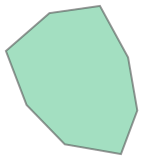

In [334]:
xv = coords[plot_ixs, 0]
yv = coords[plot_ixs, 1]
#polygon = np.array([[int(i[0]), int(i[1])] for i in coords[np.unique(inds)]])
polygon = list(zip(xv, yv))
p = MultiPoint(polygon).convex_hull
#p = Polygon(list(zip(xv, yv)))
p

In [335]:
# Extract the point values that define the perimeter of the polygon
px, py = p.exterior.coords.xy
int_px = [int(i) for i in px]
int_py = [int(i) for i in py]
#poly = list(zip(px, py))
poly = list(zip(int_px, int_py))


In [336]:
ix =7700

In [316]:
#im = im[y1:y2, x1:x2]
clip = vp(fname=video_fpath, fps=30)
im = clip.load_frame()
img = Image.fromarray(np.uint8(im)) #*255)
ImageDraw.Draw(img).polygon(poly, outline=1, fill=0)
mask = np.array(img)

In [337]:
tx, ty = ctrs[ix, :]

In [338]:
rows, cols, _ = np.array(im).shape
M = np.float32([[1,0, -tx],[0,1, -ty]])
dst = cv2.warpAffine(im,M,(cols,rows))

In [339]:
im.shape

(2160, 3840, 3)

In [340]:
R, theta = get_2d_rotmat(ix, df_ctr, v=v)

M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta,1)
dst2 = cv2.warpAffine(dst, M, (cols,rows))

<IPython.core.display.Javascript object>


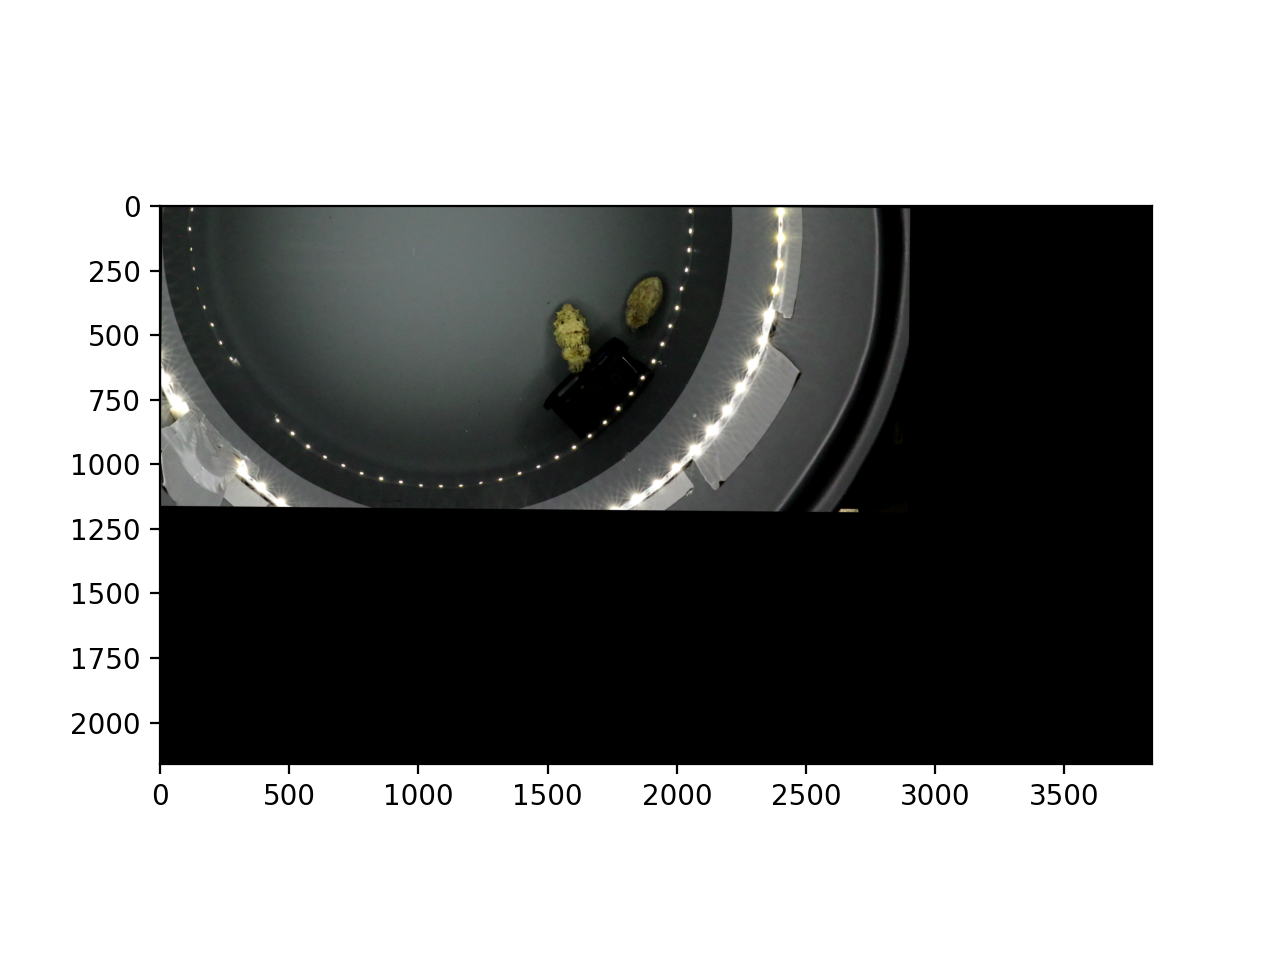

In [341]:
fig, ax = plt.subplots()
ax.imshow(dst2 )
ax.set_aspect('equal')
# ax.set_xlim(-nx/2, nx/2)
# ax.set_ylim(-ny/2, ny/2)

In [219]:
mask.dtype

dtype('uint8')

In [221]:
import cv2

In [299]:
# cv2.drawContours(mask, [np.array(poly)], -1, (255, 255, 255), -1, cv2.LINE_AA)

In [224]:

res = cv2.bitwise_and(im_uint,im_uint,mask = mask)
rect = cv2.boundingRect(poly) # returns (x,y,w,h) of the rect
cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
cropped

error: OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1658717191830/work/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


In [245]:
pts = poly.copy()
pts[:, 0] -= ctrs[ix, 0]
pts[:, 1] -= ctrs[ix, 1]

TypeError: list indices must be integers or slices, not tuple

In [300]:
im = clip.load_frame()
im = im[y1:y2, x1:x2]

In [305]:
## (1) Crop the bounding rect
# 
rect = cv2.boundingRect(np.array(poly))
x,y,w,h = rect
croped = im[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - np.array(pts).min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [np.array(pts_int)], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)


In [306]:
poly_ft = list(zip(px, py))
# poly = list(zip(int_px, int_py))


In [307]:
pts = np.array(poly_ft.copy())
pts[:, 0] -= ctrs[ix, 0]
pts[:, 1] -= ctrs[ix, 1]

In [308]:
pts_int = [[int(i[0]), int(i[1])] for i in list(pts)]
pts_int

[[41, -79],
 [-14, -69],
 [-53, -30],
 [-74, 24],
 [-30, 62],
 [20, 69],
 [48, 17],
 [57, -35],
 [41, -79]]

<IPython.core.display.Javascript object>


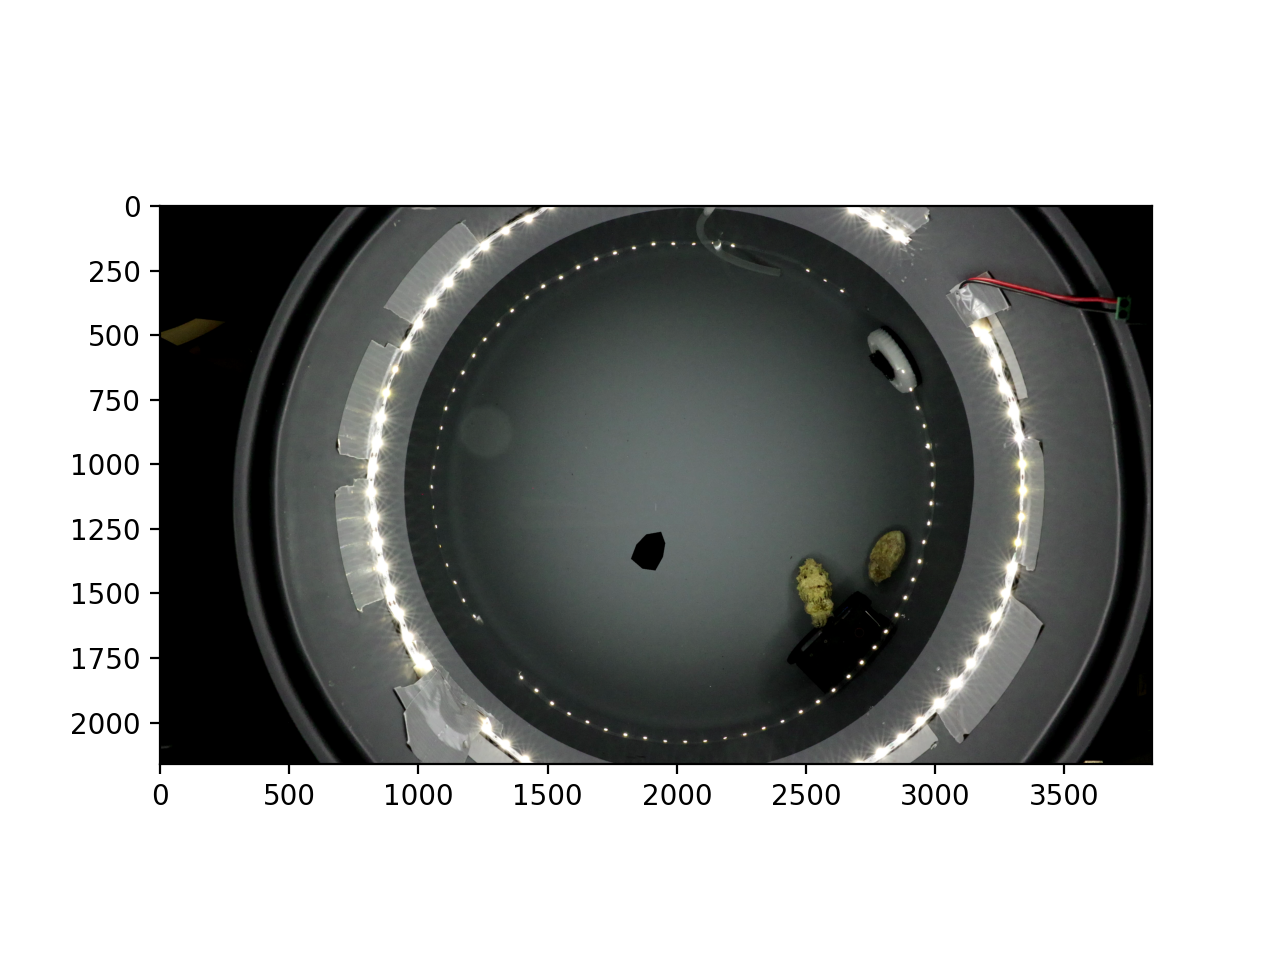

In [313]:
fig, ax = plt.subplots()
ax.imshow(mask)

In [303]:
ctrs.shape

(8991, 2)